In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# from src.models import *
from ilan_src.models import *
from src.dataloader import *
from src.utils import *
from src.evaluation import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

## Set up dataset - my way

In [3]:
DATADRIVE = '/home/jupyter/data/'

In [4]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2018-01', '2018-01'),
    val_days=5,
    split='train',
    tp_log=0.01
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [5]:
ds_test = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2020-01', '2020-12'),
    first_days=5,
    tp_log=0.01,
    mins=ds_train.mins,
    maxs=ds_train.maxs
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
sampler_test = torch.utils.data.SequentialSampler(ds_test)
dl_test = torch.utils.data.DataLoader(
    ds_test, batch_size=32, sampler=sampler_test
)

In [7]:
ds_test_small = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2020-01', '2020-01'),
    first_days=2,
    tp_log=0.01,
    mins=ds_train.mins,
    maxs=ds_train.maxs
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [8]:
sampler_test_small = torch.utils.data.SequentialSampler(ds_test_small)
dl_test_small = torch.utils.data.DataLoader(
    ds_test_small, batch_size=32, sampler=sampler_test_small
)

### Ilan's dataset

In [ ]:
ds_test2 = pickle.load(open("/home/jupyter/data/saved_datasets/testdataset_single_forecast_only_log_trans_sample.pkl", "rb"))

In [ ]:
sampler_test2 = torch.utils.data.SequentialSampler(ds_test2)
dl_test2 = torch.utils.data.DataLoader(
    ds_test2, batch_size=64, sampler=sampler_test2
)

In [57]:
ds_test[0][0][0, 0, 0]

0.4421676

In [58]:
ds_test2[0][0][0, 0, 0]

0.3974892

## Load model

In [9]:
gan = LeinGANGP.load_from_checkpoint("/home/jupyter/data/saved_models/leingan/single_forecast/0/epoch=120-step=324279.ckpt")

In [10]:
gen = gan.gen
gen = gen.to(device)
gen.train(False);

## Ilan's evaluation

In [12]:
def plot_samples_per_input(cond, target, gen, k=1, samples = 3):
    fig, axs = plt.subplots(k, samples+2, figsize=(15, k*5))
    gen_images = np.zeros((k,samples+2,128,128))
    with torch.no_grad():    
        for i in range(4):
            noise = torch.randn(cond.shape[0], 1, cond.shape[2], cond.shape[3]).to(device)
            pred = gen(cond, noise).detach().cpu().numpy()
            for j in range(k):
                gen_images[j,i,:,:] = pred[j, 0] 

    for j in range(k):
        lr = cond[j, 0].detach().cpu().numpy()
        if lr.shape[0]==64:
            lr = lr[24:40, 24:40]
        hr = target[j, 0].detach().cpu().numpy()
        mn = np.min([np.min(hr), np.min(pred), np.min(gen_images[j,i,:,:])])
        mx = np.max([np.max(hr), np.max(pred), np.max(gen_images[j,i,:,:])])
        im = axs[j,0].imshow(lr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        im = axs[j,1].imshow(hr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        for i in range(samples):
            im = axs[j,i+2].imshow(gen_images[j,i,:,:], vmin=mn, vmax=mx, cmap='gist_ncar_r')
#             plt.colorbar(im, ax=axs[j,i], shrink=0.7)
    plt.show()  

In [17]:
x_sample, y_sample = next(iter(dl_test))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)
# plot_samples_per_input(x_sample, y_sample, gen, k=16)

### Patch evaluation

In [41]:
num_samples=10
scores = gen_patch_eval(
    gen, 
    dl_test_small, 
    num_samples, 
    ds_test_small.mins.tp.values, 
    ds_test_small.maxs.tp.values, 
    ds_test_small.tp_log, 
    device
)

batch 0 out of 4
metrics took 5.379225 seconds.
batch 1 out of 4
metrics took 5.407562 seconds.
batch 2 out of 4
metrics took 5.341427 seconds.
batch 3 out of 4
metrics took 0.946686 seconds.


In [42]:
scores

(0.32465395752506965,
 0.444688116088458,
 0.3218651547988402,
 <xarray.DataArray (rank: 11)>
 array([227523., 174535., 157127., 148649., 142779., 136920., 133902.,
        130989., 132315., 138849., 245884.])
 Dimensions without coordinates: rank,
 (<xarray.DataArray (forecast_probability: 9)>
  array([0.03172549, 0.16364529, 0.31069911, 0.        , 0.42108236,
         0.50461072, 0.57405935, 0.        , 0.6304834 ])
  Coordinates:
    * forecast_probability  (forecast_probability) float64 0.05 0.15 ... 0.75 0.85,
  None,
  <xarray.DataArray 'samples' (forecast_probability: 9)>
  array([1041686.,  158868.,  155826.,       0.,   53106.,   94996.,
           46537.,       0.,   98821.])
  Coordinates:
    * forecast_probability  (forecast_probability) float64 0.05 0.15 ... 0.75 0.85),
 0.68224376)

## My full field eval

In [11]:
ds_test = ds_test_small

In [12]:
def create_valid_predictions(model, ds_valid):
    # Get predictions for full field
    preds = []
    for t in tqdm.tqdm(range(len(ds_valid.tigge.valid_time))):
        X, y = ds_valid.return_full_array(t)
        noise = torch.randn(1, X.shape[0], X.shape[1], X.shape[2]).to(device)
        pred = model(torch.FloatTensor(X[None]).to(device), noise).to('cpu').detach().numpy()[0, 0]
        preds.append(pred)
    preds = np.array(preds)
    
    # Unscale
    preds = preds * (ds_valid.maxs.tp.values - ds_valid.mins.tp.values) + ds_valid.mins.tp.values
    
    # Un-log
    if ds_valid.tp_log:
        preds = log_retrans(preds, ds_valid.tp_log)
    
    # Convert to xarray
    preds = xr.DataArray(
        preds,
        dims=['valid_time', 'lat', 'lon'],
        coords={
            'valid_time': ds_valid.tigge.valid_time,
            'lat': ds_valid.mrms.lat.isel(
                lat=slice(ds_valid.pad_mrms, ds_valid.pad_mrms+preds.shape[1])
            ),
            'lon': ds_valid.mrms.lon.isel(
                lon=slice(ds_valid.pad_mrms, ds_valid.pad_mrms+preds.shape[2])
            )
        },
        name='tp'
    )
    return preds

In [13]:
def create_valid_ensemble(model, ds_valid, nens):
    """Wrapper to create ensemble"""
    preds = [create_valid_predictions(model, ds_valid) for _ in range(nens)]
    return xr.concat(preds, 'member')

In [14]:
%%time
det_pred = create_valid_predictions(gen, ds_test)

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 1min 45s, sys: 8.74 s, total: 1min 54s
Wall time: 30.4 s


### Ensemble

In [15]:
%%time
ens_pred = create_valid_ensemble(gen, ds_test_small, nens=10)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 17min 36s, sys: 1min, total: 18min 36s
Wall time: 4min 56s


## Get ground truth

In [16]:
mrms = ds_test.mrms.sel(lat=det_pred.lat, lon=det_pred.lon).rename(
    {'time': 'valid_time'}) * ds_test.maxs.tp.values
mrms = log_retrans(mrms, ds_test.tp_log)

## Get interpolation baseline

In [17]:
tigge = ds_test.tigge.isel(variable=0) * ds_test.maxs.tp.values
tigge = log_retrans(tigge, ds_test.tp_log)

In [18]:
interp = tigge.interp_like(mrms, method='linear')

In [24]:
interp

<xarray.DataArray (valid_time: 3, lat: 744, lon: 1376)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.28450694,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.29019327,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.2958796 ,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 0.01148081,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.01077673,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.01007264,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.44153307,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.45971748,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.47790188,
                nan,        nan]]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    variable    <U2 'tp'
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0

## Get HRRR baselines

In [20]:
fn = f'{DATADRIVE}/hrrr/4km/total_precipitation/2020*.nc'
hrrr = xr.open_mfdataset(fn)

In [21]:
hrrr = hrrr.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [22]:
hrrr['valid_time'] = hrrr.init_time + hrrr.lead_time
hrrr = hrrr.swap_dims({'init_time': 'valid_time'})

In [23]:
hrrr = hrrr.sel(valid_time=interp.valid_time)
hrrr

<xarray.DataArray 'tp' (valid_time: 3, lat: 750, lon: 1376)>
dask.array<getitem, shape=(3, 750, 1376), dtype=float32, chunksize=(1, 750, 1376), chunktype=numpy.ndarray>
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   (valid_time) datetime64[ns] 2020-01-01 ... 2020-01-02
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-0...
    variable    <U2 'tp'

## TIGGE Ensemble

## HREF

In [25]:
fn = f'{DATADRIVE}/href/4km/total_precipitation/2020*.nc'
href = xr.open_mfdataset(fn)

In [26]:
href = href.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [28]:
href = href.swap_dims({'init_time': 'valid_time'})

In [31]:
href

,Array,Chunk
Bytes,27.91 GiB,39.37 MiB
Shape,"(10, 726, 750, 1376)","(10, 1, 750, 1376)"
Count,5082 Tasks,726 Chunks
Type,float32,numpy.ndarray


In [30]:
interp.valid_time

<xarray.DataArray 'valid_time' (valid_time: 3)>
array(['2020-01-01T12:00:00.000000000', '2020-01-02T00:00:00.000000000',
       '2020-01-02T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    variable    <U2 'tp'
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-0...

In [29]:
href = href.sel(valid_time=interp.valid_time)

KeyError: "not all values found in index 'valid_time'"

## Get mask

In [32]:
ds = xr.open_dataset(
    '/home/jupyter/data/hrrr/raw/total_precipitation/20180215_00.nc')

In [33]:
from src.regrid import *

In [34]:
ds_regridded = regrid(ds, 4, lons=(235, 290), lats=(50, 20))

/opt/conda/envs/ilan/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [35]:
hrrr_mask = np.isfinite(ds_regridded).tp.isel(init_time=0, lead_time=0)

In [36]:
rq = xr.open_dataarray(f'{DATADRIVE}/mrms/4km/RadarQuality.nc')
mrms_mask = rq>-1
mrms_mask = mrms_mask.assign_coords({
    'lat': hrrr_mask.lat,
    'lon': hrrr_mask.lon
})

In [37]:
total_mask = mrms_mask * hrrr_mask

In [38]:
total_mask = total_mask.isel(lat=slice(0, -6))

In [39]:
total_mask = total_mask.assign_coords({'lat': interp.lat.values, 'lon': interp.lon.values})

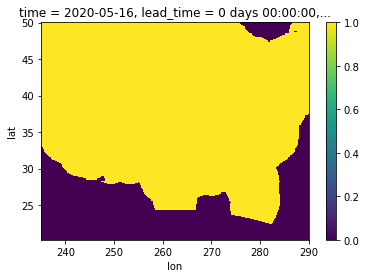

In [40]:
total_mask.plot()

## Compute scores

In [41]:
hrrr = hrrr.isel(lat=slice(0, -6))

In [42]:
hrrr = hrrr.assign_coords({'lat': interp.lat.values, 'lon': interp.lon.values})

In [43]:
# Apply mask
mrms = mrms.where(total_mask)
det_pred = det_pred.where(total_mask)
hrrr = hrrr.where(total_mask)
interp = interp.where(total_mask)

In [44]:
hrrr.load()

<xarray.DataArray 'tp' (valid_time: 3, lat: 744, lon: 1376)>
array([[[0.        , 0.        , 0.        , ..., 0.25020915,
         0.16021901, 0.08577618],
        [0.        , 0.        , 0.        , ..., 0.55257535,
         0.50840634, 0.45015085],
        [0.        , 0.        , 0.        , ..., 0.6211469 ,
         0.6075462 , 0.6050905 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-0...
    variable    <U2 'tp'
    time        datetime64[ns] 2020-05-16

## Bias

In [45]:
mrms.mean().values

array(0.33578843)

In [46]:
det_pred.mean().values

array(0.34051946, dtype=float32)

In [47]:
interp.mean().values

array(0.46983967)

In [48]:
hrrr.mean().values

array(0.4390679, dtype=float32)

### Histograms

In [49]:
bins = np.logspace(0, 2, 25)-1
mid_bin = (bins[1:] + bins[:-1])/2

In [50]:
def plot_hist(ds, bins, label):
    nums, bins = np.histogram(ds.values, bins=bins)
    plt.plot(mid_bin, nums, marker='o', label=label)

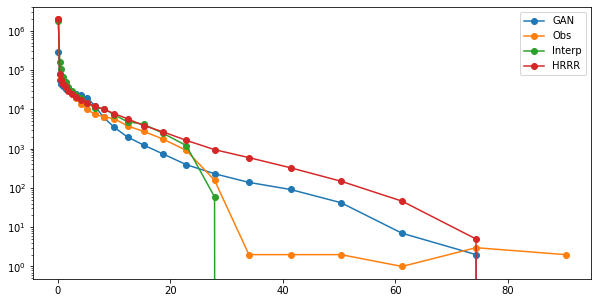

In [51]:
plt.figure(figsize=(10, 5))
plot_hist(det_pred, bins, 'GAN')
plot_hist(mrms, bins, 'Obs')
plot_hist(interp, bins, 'Interp')
plot_hist(hrrr, bins, 'HRRR')
plt.yscale('log')
plt.legend()

### RMSE

In [52]:
xs.rmse(det_pred, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.48187827)

In [53]:
xs.rmse(interp, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.27254274)

In [54]:
xs.rmse(hrrr, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.91203994)

### FSS

In [55]:
thresh = 10
window = 100 // 4

In [56]:
def compute_fss(f, o, thresh, window, time_mean=True):
    f_thresh = f > thresh
    o_thresh = o > thresh
    f_frac = f_thresh.rolling({'lat': window, 'lon': window}, center=True).mean()
    o_frac = o_thresh.rolling({'lat': window, 'lon': window}, center=True).mean()
    mse = ((f_frac - o_frac)**2).mean(('lat', 'lon'))
    mse_ref = (f_frac**2).mean(('lat', 'lon')) + (o_frac**2).mean(('lat', 'lon'))
    fss = 1 - mse / mse_ref
    if time_mean:
        fss = fss.mean('valid_time')
    return fss

In [57]:
compute_fss(mrms, det_pred, thresh, window).values

array(0.08515959)

In [58]:
compute_fss(mrms, interp, thresh, window).values

array(0.38390918)

In [59]:
compute_fss(mrms, hrrr, thresh, window).values

array(0.19300739)

## Plotting

In [74]:
def plot(da):
    fig, ax = plt.subplots(figsize=(20, 10))
    da.plot(vmin=0, vmax=20, cmap='gist_ncar_r')
    ax.set_aspect('equal')

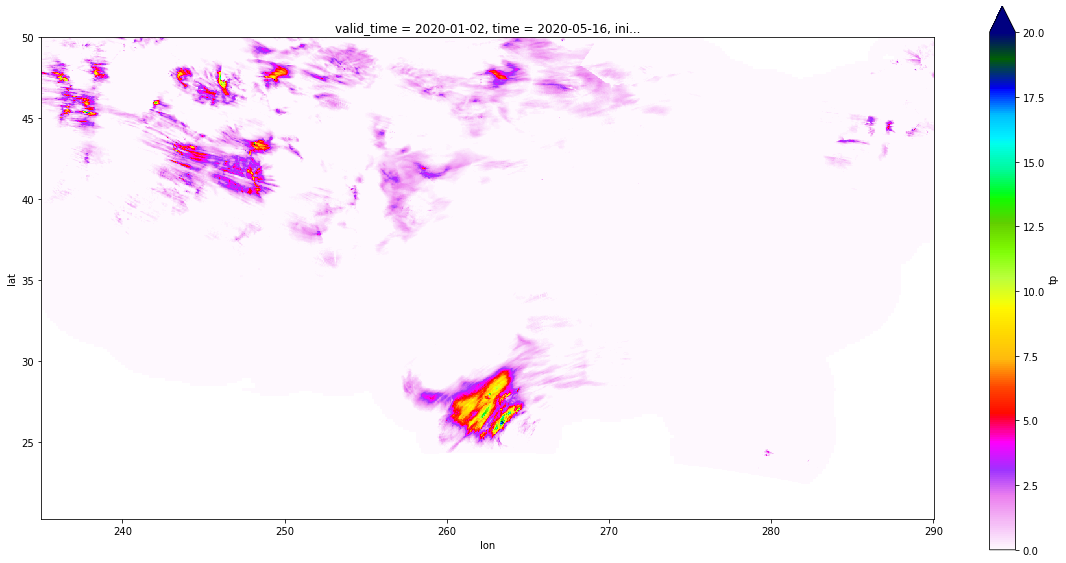

In [75]:
plot(mrms[1])

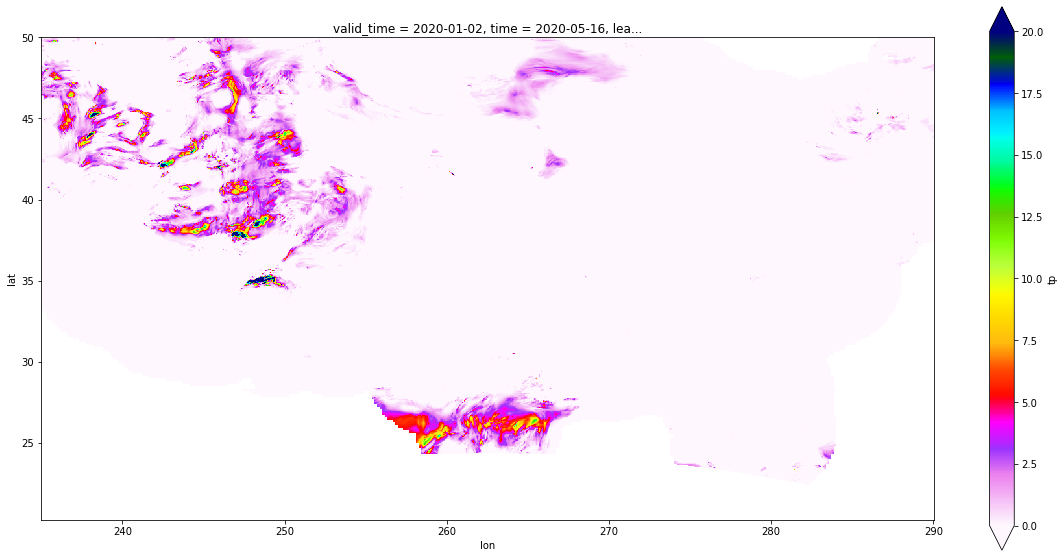

In [76]:
plot(det_pred[1])

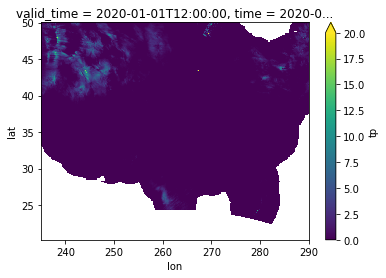

In [61]:

mrms[0].plot(vmin=0, vmax=20)

In [ ]:
det_pred[50].plot(vmin=0, vmax=20)

In [ ]:
interp[50].plot(vmin=0, vmax=20)

In [ ]:
hrrr[50].plot(vmin=0, vmax=20)